# REQUIREMENT #1


Requirement #1 

Steps we will take throughout this ipynb. 

1. Set up & clean the data
2. Build content-based recommender
3. Build collaborative filtering recommender
4. Combine them in a hybrid system
5. Test recommendations for a given show/user

# **CONTENT FILTERING**


# DATA IMPORT

In [1]:
# Step 1: Import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Don't forget to mount Google Drive if you haven't already:
# from google.colab import drive
# drive.mount('/content/drive')

df = pd.read_csv('movies_titles.csv')
df.head()

,show_id,type,title,director,cast,country,release_year,rating,duration,description,...,Language TV Shows,Musicals,Nature TV,Reality TV,Spirituality,TV Action,TV Comedies,TV Dramas,Talk Shows TV Comedies,Thrillers
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2020,PG-13,90 min,As her father nears the end of his life filmma...,...,0,0,0,0,0,0,0,0,0,0
1,s2,TV Show,Blood & Water,NaN,Ama Qamata Khosi Ngema Gail Mabalane Thabang M...,South Africa,2021,TV-MA,2 Seasons,After crossing paths at a party a Cape Town te...,...,0,0,0,0,0,0,0,1,0,0
2,s3,TV Show,Ganglands,Julien Leclercq,Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...,NaN,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,...,0,0,0,0,0,1,0,0,0,0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021,TV-MA,1 Season,Feuds flirtations and toilet talk go down amon...,...,0,0,0,1,0,0,0,0,0,0
4,s5,TV Show,Kota Factory,NaN,Mayur More Jitendra Kumar Ranjan Raj Alam Khan...,India,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,...,0,0,0,0,0,0,1,0,0,0


# DATA UNDERSTANDING


In [2]:
print(df.shape)
df.isna().sum()

(8508, 42)


show_id                                                  0
type                                                     0
title                                                    0
director                                              2114
cast                                                   119
country                                                814
release_year                                             0
rating                                                   4
duration                                                 1
description                                              0
Action                                                   0
Adventure                                                0
Anime Series International TV Shows                      0
British TV Shows Docuseries International TV Shows       0
Children                                                 0
Comedies                                                 0
Comedies Dramas International Movies                    

# DATA PREPARATION


In [7]:
# Replace missing text fields with 'unknown'
df['director'].fillna('unknown', inplace=True)
df['cast'].fillna('unknown', inplace=True)
df['country'].fillna('unknown', inplace=True)

# Fill duration with mode (most common value)
df['duration'].fillna(df['duration'].mode()[0], inplace=True)

# Drop rows missing 'rating'
df.dropna(subset=['rating'], inplace=True)

# Reset the index after dropping
df.reset_index(drop=True, inplace=True)

# Check again
print(df.isna().sum(), '\n')
print(df.shape)


show_id                                               0
type                                                  0
title                                                 0
director                                              0
cast                                                  0
country                                               0
release_year                                          0
rating                                                0
duration                                              0
description                                           0
Action                                                0
Adventure                                             0
Anime Series International TV Shows                   0
British TV Shows Docuseries International TV Shows    0
Children                                              0
Comedies                                              0
Comedies Dramas International Movies                  0
Comedies International Movies                   

/var/folders/m4/xg4464_s7kq5tw8wxf9_2rnm0000gn/T/ipykernel_72320/242328957.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('unknown', inplace=True)
/var/folders/m4/xg4464_s7kq5tw8wxf9_2rnm0000gn/T/ipykernel_72320/242328957.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

# MODELING PREP


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer and remove stopwords
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the 'description' field
tfidf_matrix = tfidf.fit_transform(df['description'])

# Shape of the matrix (shows x unique words)
print(tfidf_matrix.shape)


(8504, 18564)


In [8]:
df_tfidf = pd.DataFrame(tfidf_matrix.T.todense(), 
                        index=tfidf.get_feature_names_out(), 
                        columns=df['title'])

df_tfidf.iloc[2221:2226]


title,Dick Johnson Is Dead,Blood & Water,Ganglands,Jailbirds New Orleans,Kota Factory,Midnight Mass,My Little Pony: A New Generation,Sankofa,The Great British Baking Show,The Starling,...,Zak Storm,Zed Plus,Zenda,Zindagi Gulzar Hai,Zinzana,Zodiac,Zombie Dumb,Zombieland,Zoom,Zubaan
brand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
branded,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brandi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brando,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brandon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.metrics.pairwise import linear_kernel

# Compute pairwise cosine similarity between all shows
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Optional: view as a DataFrame
pd.DataFrame(cosine_sim)


,0,1,2,3,4,5,6,7,8,9,...,8494,8495,8496,8497,8498,8499,8500,8501,8502,8503
0,1.000000,0.000000,0.000000,0.000000,0.015283,0.000000,0.000000,0.000000,0.040107,0.017486,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015485,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.030973,0.052236,0.000000,0.000000,0.000000,...,0.03571,0.032478,0.118291,0.000000,0.032402,0.000000,0.041654,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022284
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016315,0.000000
4,0.015283,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.016786,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035912,0.068620,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.046180,0.052486,0.000000,0.000000,1.000000,0.000000,0.060082,0.000000,0.000000
8500,0.000000,0.041654,0.000000,0.000000,0.000000,0.054674,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.036839,0.000000,0.000000,0.036753,0.000000,1.000000,0.000000,0.000000,0.000000
8501,0.000000,0.000000,0.000000,0.000000,0.035912,0.000000,0.000000,0.000000,0.000000,0.062403,...,0.00000,0.000000,0.000000,0.042452,0.000000,0.060082,0.000000,1.000000,0.000000,0.000000
8502,0.015485,0.000000,0.000000,0.016315,0.068620,0.000000,0.000000,0.000000,0.000000,0.017008,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [11]:
# Create a title-to-index mapping
indices = pd.Series(df.index, index=df['title'].str.lower())

def get_recommendations(title, cosine_sim=cosine_sim, top_n=5):
    idx = indices[title.lower()]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    show_indices = [i[0] for i in sim_scores]
    return df.iloc[show_indices][['title', 'description']]


In [12]:
get_recommendations("Dick Johnson Is Dead")


,title,description
4732,End Game,Facing an inevitable outcome terminally ill pa...
1029,The Soul,While investigating the death of a businessman...
7250,Moon,As he nears the end of a lonely three-year sti...
4894,The Cloverfield Paradox,Orbiting above a planet on the brink of war sc...
5072,The Death and Life of Marsha P. Johnson,As she fights the tide of violence against tra...


# **COLLABORATIVE FILTERING**

# DATA IMPORT

In [13]:
import pandas as pd

# Load CineNiche's ratings data
df_triple = pd.read_csv('movies_ratings.csv')

# Sort like in the textbook example (for consistency, though not strictly required)
df_triple.sort_values(by=['user_id', 'show_id'], inplace=True)

# Preview the result
df_triple.head()


,user_id,show_id,rating
7,1,s2361,3
10,1,s242,3
5,1,s2917,3
3,1,s294,3
2,1,s3181,4


# DATA UNDERSTANDING

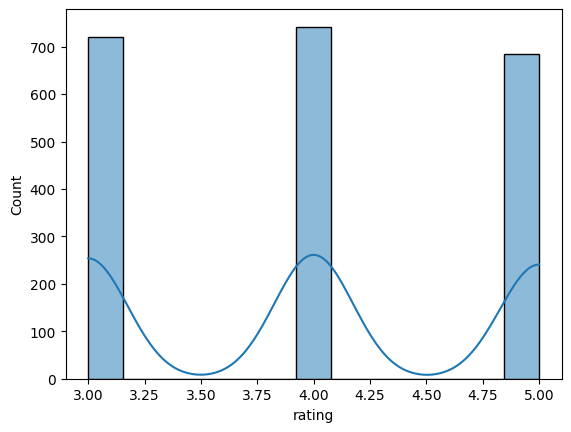

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_triple, x='rating', kde=True);


In [15]:
n_ratings = len(df_triple)
n_movies = df_triple['show_id'].nunique()
n_users = df_triple['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique show_id's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings / n_users, 2)}")
print(f"Average ratings per show: {round(n_ratings / n_movies, 2)}")


Number of ratings: 2147
Number of unique show_id's: 1809
Number of unique users: 200
Average ratings per user: 10.73
Average ratings per show: 1.19


In [16]:
# Count how many ratings each show has received
df_triple['show_id'].value_counts()


show_id
s6508    4
s8804    4
s3282    4
s540     4
s2179    4
        ..
s324     1
s3879    1
s7082    1
s1378    1
s2917    1
Name: count, Length: 1809, dtype: int64

In [17]:
rating_counts = df_triple['show_id'].value_counts()

print('Min:\t\t', rating_counts.min())
print('Quartile 1:\t', rating_counts.quantile(0.25))
print('Median:\t\t', rating_counts.quantile(0.5))
print('Quartile 3:\t', rating_counts.quantile(0.75))
print('Max:\t\t', rating_counts.max())


Min:		 1
Quartile 1:	 1.0
Median:		 1.0
Quartile 3:	 1.0
Max:		 4


# DATA PREPARATION

In [20]:
# Count how many times each show has been rated
value_counts = df_triple['show_id'].value_counts()

# Keep only shows with 4 or more ratings
keep_list = value_counts[value_counts >= 1]
print(len(keep_list), 'shows with 4 or more ratings\n')


1809 shows with 4 or more ratings



In [21]:
# Filter df_triple down to only those popular shows
df_triple = df_triple[df_triple['show_id'].isin(keep_list.index)]
print(df_triple.shape)
print("Ratings per show:\t", round(df_triple.shape[0] / len(keep_list), 2))


(2147, 3)
Ratings per show:	 1.19


In [22]:
# Check for duplicate user-show pairs
print(f"Duplicate ratings: {df_triple.duplicated(subset=['user_id', 'show_id']).sum()}")

# Drop duplicates, keep first
print(f'Total rows before dropping duplicates: {df_triple.shape[0]}')
df_triple.drop_duplicates(subset=['user_id', 'show_id'], keep='first', inplace=True)
print(f'Total rows after dropping duplicates: {df_triple.shape[0]}')


Duplicate ratings: 0
Total rows before dropping duplicates: 2147
Total rows after dropping duplicates: 2147


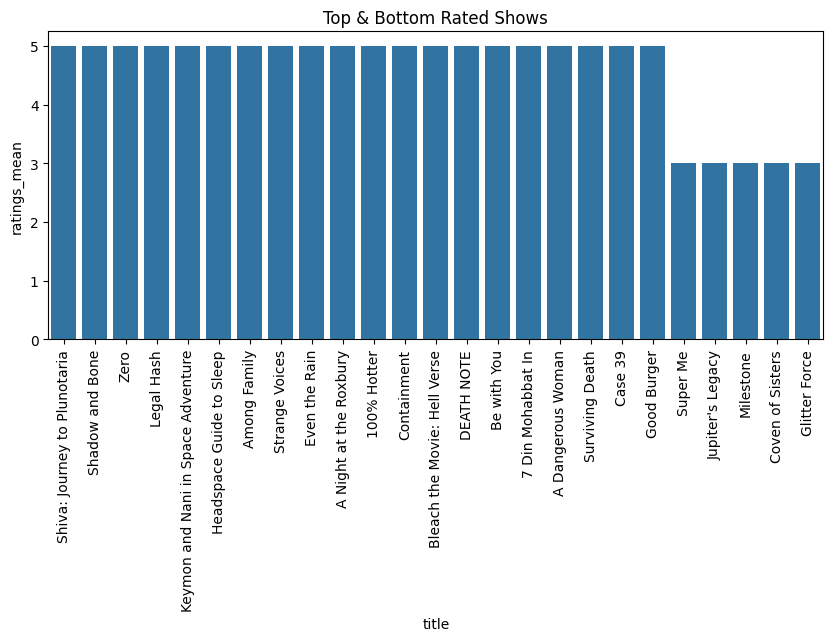

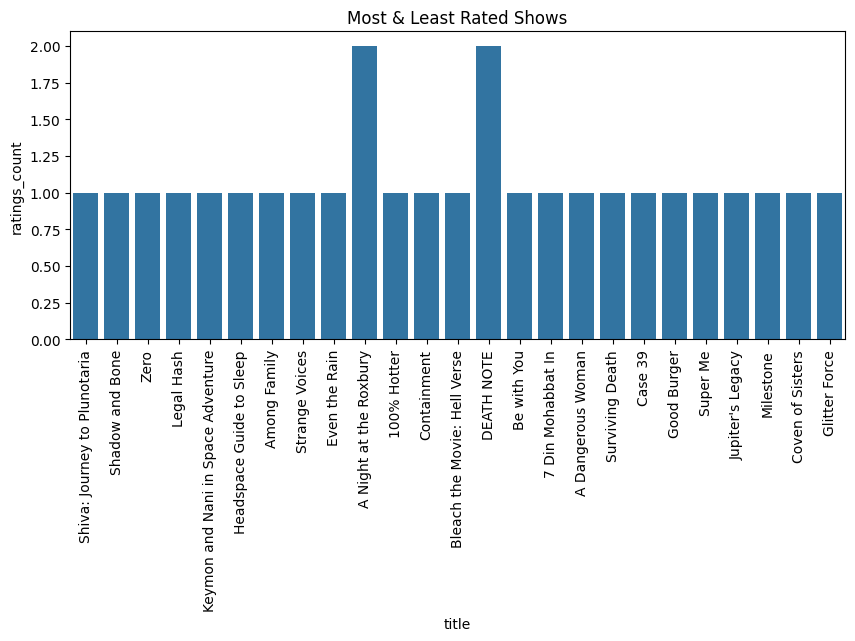

In [23]:
df_movies = pd.read_csv('movies_titles.csv')

# Merge to get titles
movie_stats = df_triple.groupby('show_id')[['rating']].agg(['count', 'mean'])
movie_stats.columns = ['ratings_count', 'ratings_mean']

# Join with title names
movie_stats = movie_stats.join(df_movies.set_index('show_id')['title'])

# Sort by rating
movie_stats = movie_stats.sort_values(by='ratings_mean', ascending=False)

# Create a reduced df with top & bottom rated shows
df_reduced = pd.concat([movie_stats.head(20), movie_stats.tail(5)])

# Plot average rating
plt.figure(figsize=(10, 4))
sns.barplot(data=df_reduced, x='title', y='ratings_mean')
plt.xticks(rotation=90)
plt.title("Top & Bottom Rated Shows")
plt.show()

# Plot rating count
plt.figure(figsize=(10, 4))
sns.barplot(data=df_reduced, x='title', y='ratings_count')
plt.xticks(rotation=90)
plt.title("Most & Least Rated Shows")
plt.show()


# MODELING

In [25]:
import numpy as np
from scipy.sparse import csr_matrix

# Number of users and items
U = df_triple['user_id'].nunique()
I = df_triple['show_id'].nunique()

# Map user_id and show_id to indices
user_mapper = dict(zip(np.unique(df_triple['user_id']), list(range(U))))
item_mapper = dict(zip(np.unique(df_triple['show_id']), list(range(I))))

# Map indices back to original IDs
user_inv_mapper = dict(zip(list(range(U)), np.unique(df_triple['user_id'])))
item_inv_mapper = dict(zip(list(range(I)), np.unique(df_triple['show_id'])))

# Create index lists for matrix construction
user_index = [user_mapper[i] for i in df_triple['user_id']]
item_index = [item_mapper[i] for i in df_triple['show_id']]

# Build the sparse matrix: rows=items, cols=users
X = csr_matrix((df_triple['rating'], (item_index, user_index)), shape=(I, U))

# Print outputs for understanding
print(f'Number of users: {U}')
print(f'Number of items: {I}')
print(f'user_mapper:\t {len(user_mapper)} keys')
print(f'item_mapper:\t {len(item_mapper)} keys')
print(f'user_index:\t {len(user_index)} values (first 10): {user_index[:10]}')
print(f'item_index:\t {len(item_index)} values (first 10): {item_index[:10]}')
print(f'user_inv_mapper:\t {len(user_inv_mapper)} keys')
print(f'item_inv_mapper:\t {len(item_inv_mapper)} keys')
print(f'Sparse matrix X:\n{X}')


Number of users: 200
Number of items: 1809
user_mapper:	 200 keys
item_mapper:	 1809 keys
user_index:	 2147 values (first 10): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
item_index:	 2147 values (first 10): [318, 337, 446, 454, 508, 577, 953, 1160, 1454, 1537]
user_inv_mapper:	 200 keys
item_inv_mapper:	 1809 keys
Sparse matrix X:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2147 stored elements and shape (1809, 200)>
  Coords	Values
  (0, 179)	5
  (1, 103)	3
  (2, 67)	5
  (3, 99)	4
  (4, 144)	5
  (5, 158)	3
  (6, 50)	3
  (6, 124)	3
  (7, 171)	5
  (8, 19)	5
  (8, 78)	5
  (8, 138)	4
  (9, 4)	5
  (9, 160)	4
  (10, 176)	5
  (11, 121)	3
  (12, 112)	3
  (13, 136)	4
  (14, 78)	5
  (15, 132)	3
  (16, 142)	4
  (16, 193)	4
  (17, 52)	4
  (18, 53)	3
  (18, 54)	4
  :	:
  (1785, 28)	5
  (1786, 180)	3
  (1787, 1)	3
  (1788, 151)	3
  (1789, 47)	4
  (1789, 165)	3
  (1790, 24)	4
  (1791, 148)	3
  (1792, 35)	4
  (1793, 30)	4
  (1794, 166)	4
  (1795, 142)	4
  (1796, 110)	4
  (1797, 69)	3
  (1798, 175

In [26]:
import numpy as np
from scipy.sparse import csr_matrix

# Function to build the matrix and mappers
def create_matrix(df, user, item, rating):
    U = df[user].nunique()  # Number of users
    I = df[item].nunique()  # Number of items (shows)

    # Create ID-to-index mappings
    user_mapper = dict(zip(np.unique(df[user]), list(range(U))))
    item_mapper = dict(zip(np.unique(df[item]), list(range(I))))

    # Create index-to-ID (inverse) mappings
    user_inv_mapper = dict(zip(list(range(U)), np.unique(df[user])))
    item_inv_mapper = dict(zip(list(range(I)), np.unique(df[item])))

    # Index positions for matrix
    user_index = [user_mapper[i] for i in df[user]]
    item_index = [item_mapper[i] for i in df[item]]

    # Build the sparse matrix (items as rows, users as columns)
    X = csr_matrix((df[rating], (item_index, user_index)), shape=(I, U))

    return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper


In [27]:
# Call the function with your actual column names
X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_matrix(
    df_triple, 'user_id', 'show_id', 'rating'
)

# Print results to understand the mappings
print("Sparse Matrix X:")
print(X)

print("\nUser Mapper:")
print(user_mapper)

print("\nUser Inverse Mapper:")
print(user_inv_mapper)

print("\nItem (Show) Mapper:")
print(item_mapper)

print("\nItem (Show) Inverse Mapper:")
print(item_inv_mapper)


Sparse Matrix X:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2147 stored elements and shape (1809, 200)>
  Coords	Values
  (0, 179)	5
  (1, 103)	3
  (2, 67)	5
  (3, 99)	4
  (4, 144)	5
  (5, 158)	3
  (6, 50)	3
  (6, 124)	3
  (7, 171)	5
  (8, 19)	5
  (8, 78)	5
  (8, 138)	4
  (9, 4)	5
  (9, 160)	4
  (10, 176)	5
  (11, 121)	3
  (12, 112)	3
  (13, 136)	4
  (14, 78)	5
  (15, 132)	3
  (16, 142)	4
  (16, 193)	4
  (17, 52)	4
  (18, 53)	3
  (18, 54)	4
  :	:
  (1785, 28)	5
  (1786, 180)	3
  (1787, 1)	3
  (1788, 151)	3
  (1789, 47)	4
  (1789, 165)	3
  (1790, 24)	4
  (1791, 148)	3
  (1792, 35)	4
  (1793, 30)	4
  (1794, 166)	4
  (1795, 142)	4
  (1796, 110)	4
  (1797, 69)	3
  (1798, 175)	3
  (1799, 65)	4
  (1800, 180)	3
  (1801, 170)	5
  (1802, 155)	4
  (1803, 125)	5
  (1804, 184)	5
  (1805, 40)	5
  (1806, 33)	5
  (1807, 33)	3
  (1808, 120)	5

User Mapper:
{np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(6): 5, np.int64(7): 6, np.int64(8): 7, n

In [28]:
def recommend(itemId, X, item_mapper, item_inv_mapper, k, metric='cosine', messages=True):
    from sklearn.neighbors import NearestNeighbors
    import numpy as np

    rec_ids = []                # Recommended item IDs
    item = item_mapper[itemId]  # Index of the given show_id
    item_vector = X[item]       # Row vector for that item in the matrix

    # Fit the KNN model
    knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric).fit(X)

    # Find k nearest neighbors
    rec = knn.kneighbors(item_vector.reshape(1, -1), return_distance=True)
    rec_indices = rec[1][0]     # Indices of recommended items
    rec_distances = rec[0][0]   # Distances (similarity scores)
    rec_distances = np.delete(rec_distances, 0)  # Remove self-distance

    # Convert matrix indices back to original show_ids
    for i in range(1, knn.n_neighbors):
        rec_ids.append(item_inv_mapper[rec_indices[i]])

    if messages:
        print(f'List of recommended item indices:\n{rec_indices}\n')
        print(f'List of recommended show IDs:\n{rec_ids}\n')
        print(f'List of similarity scores:\n{rec_distances}\n')

    return rec_ids, rec_distances


In [29]:
# Pick a valid show_id that exists in your data
movie_id = df_triple['show_id'].iloc[0]  # or use a known one manually

# Get recommendations (returns both IDs and distances)
similar_ids, distances = recommend(movie_id, X, item_mapper, item_inv_mapper, k=10)

# Show the title of the selected show
selected_title = df_movies[df_movies['show_id'] == movie_id]['title'].values[0]
print(f"If you like {selected_title}, you may also enjoy:\n")

# Loop through recommendations and print their titles
for sid in similar_ids:
    title_match = df_movies[df_movies['show_id'] == sid]['title'].values
    if len(title_match) > 0:
        print(f"\t{title_match[0]}")


List of recommended item indices:
[1680 1537 1454  953  508  577  454  446  318  337 1160]

List of recommended show IDs:
['s7739', 's7361', 's493', 's3181', 's3466', 's294', 's2917', 's2361', 's242', 's5899']

List of similarity scores:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.21913119]

If you like One-Way to Tomorrow, you may also enjoy:

	Phone Swap
	Lucky: No Time for Love
	Midnight Sun
	A Christmas Prince: The Royal Baby
	First Kiss
	Slay
	Panipat - The Great Betrayal
	One-Way to Tomorrow
	Manifest
	6 Years
